In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

from scipy.spatial import distance_matrix, distance
from tqdm.notebook import tqdm
from collections import defaultdict
from IPython.display import clear_output

In [2]:
columns =[ 
'Profile_mean',
'Profile_stdev',
'Profile_skewness',
'Profile_kurtosis',
'DM_mean',
'DM_stdev',
'DM_skewness',
'DM_kurtosis',
'label'
]

In [3]:
df = pd.read_csv('HTRU2/HTRU_2.csv',header=None,names=columns)
df = df.sample(frac=0.1).reset_index(drop=True)
labels = df.label
df = df.drop(columns='label')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790 entries, 0 to 1789
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      1790 non-null   float64
 1   Profile_stdev     1790 non-null   float64
 2   Profile_skewness  1790 non-null   float64
 3   Profile_kurtosis  1790 non-null   float64
 4   DM_mean           1790 non-null   float64
 5   DM_stdev          1790 non-null   float64
 6   DM_skewness       1790 non-null   float64
 7   DM_kurtosis       1790 non-null   float64
dtypes: float64(8)
memory usage: 112.0 KB


In [4]:
df.head()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
0,129.062500,47.583274,0.034719,-0.154337,5.727425,26.594803,5.353546,31.453808
1,102.320312,38.602933,0.377556,1.240759,2.185619,17.625631,9.530584,100.988835
2,118.000000,48.656160,0.055570,-0.078968,1.088629,12.336984,14.649034,246.822866
3,130.640625,51.872852,0.145932,0.177934,9.852843,35.871311,3.869401,14.883692
4,102.953125,34.386557,0.646091,2.766828,1.887124,15.579652,10.453287,131.059023


In [5]:
df.values

array([[ 1.29062500e+02,  4.75832740e+01,  3.47186640e-02, ...,
         2.65948033e+01,  5.35354616e+00,  3.14538075e+01],
       [ 1.02320312e+02,  3.86029333e+01,  3.77556005e-01, ...,
         1.76256311e+01,  9.53058409e+00,  1.00988835e+02],
       [ 1.18000000e+02,  4.86561597e+01,  5.55701750e-02, ...,
         1.23369840e+01,  1.46490345e+01,  2.46822866e+02],
       ...,
       [ 1.46156250e+02,  5.70882592e+01, -2.98125307e-01, ...,
         1.57747493e+01,  8.80829989e+00,  9.82645936e+01],
       [ 9.31015625e+01,  4.47480516e+01,  5.01497565e-01, ...,
         2.32835289e+01,  7.46817115e+00,  5.74580838e+01],
       [ 1.13398438e+02,  5.17784251e+01,  2.62187455e-01, ...,
         1.80935576e+01,  1.04315859e+01,  1.13040611e+02]])

In [6]:
dissimilarity = pd.DataFrame(distance_matrix(df.values, df.values),index=df.index,columns=df.index)
norm_diss = np.array(dissimilarity/dissimilarity.iloc[np.argmin(dissimilarity.sum())].sum())
E = np.array(df)

In [7]:
## Inicialização de parâmetros

n_iter = 50
q = 5
n = 1.1
x = 2
y = 2
C = int(x*y)
N = E.shape[0]
sigma_0 = np.sqrt(-(C+C)/2*np.log(0.1))
sigma_f = np.sqrt(-1/2*np.log(0.01))
print('Sigma_0', sigma_0, '\nSigma_f', sigma_f)

Sigma_0 3.0348542587702925 
Sigma_f 1.5174271293851462


In [8]:
def calc_sigma(t):
    return sigma_0*pow((sigma_f/sigma_0),t/50)

def calc_h(nodes,s,r,sigma):
    s=int(s)
    r=int(r)
    dist = delta[i,j]
    return np.exp(-dist/2*np.square(sigma))

def D_vr(e,r):
    G_r = G[r]
    return sum(
        [np.power(v[r,i],n)*norm_diss[e,G_r[i]] for i in range(v.shape[1])]
    )

# def create_delta_matrix(x,y):
nodes = []
for i in range(1,x+1):
    for j in range(1,y+1):
        nodes.append([i,j])

delta = np.empty((C,C))

for i in range(delta.shape[0]):
    for j in range(delta.shape[1]):
        delta[i,j] = np.square(distance.euclidean(nodes[i],nodes[j]))

# return delta

In [9]:
t = 0
sigma = calc_sigma(0)

h_matrix = np.empty((C,C))

for i in range(h_matrix.shape[0]):
    for j in range(h_matrix.shape[1]):
        h_matrix[i,j] = calc_h(nodes,i,j,sigma)
        
G = []
for i in range(C):
    G.append(np.array(df.sample(5).index))
G=np.array(G)

v = pd.DataFrame(np.random.rand(C,5))
v_row_sum = np.array(v.sum(axis=1))
v = np.array(v)

for i in range(v.shape[0]):
    for j in range(v.shape[1]):
        v[i,j] = v[i,j]/v_row_sum[i]

In [10]:
%%time
P = [[] for i in range(C)]
clusters_array = np.zeros(N)
for k in range(N):
    #calculate f_ek
    deltas = np.empty(C)
    for s in range(C):
        val = sum(
            [
                h_matrix[s,r]*D_vr(k,r) for r in range(C)
            ]
        )

        deltas[s] = val

    k_cluster = np.argmin(deltas)
    clusters_array[k] = k_cluster
    clusters_array = clusters_array.astype(int)
    P[k_cluster].append(k)     

CPU times: user 247 ms, sys: 0 ns, total: 247 ms
Wall time: 247 ms


In [11]:
# %%time
v_t = v.copy()
for t in tqdm(range(1,150)):#range(1,n_iter+1):
    gc.collect()
#     clear_output(wait=True)
    print('Iter ',t)
    sigma_t = calc_sigma(t)
    h_t = np.empty((C,C))
    
    for i in range(C):
        for j in range(C):
            h_t[i,j] = calc_h(nodes,i,j,sigma_t)
    
    ## step 1: compute Gr
    for r in range(C):
        g = []

        for h in range(N):
            hfec = np.array([h_t[x,r] for x in clusters_array])
            dist = norm_diss[h]
            val = (dist*hfec).sum()

            g.append((h,val))
            
        g = sorted(g, key= lambda x: x[1])[:q]
        
        G[r] = np.array([pair[0] for pair in g])
    
    
#     print('Iter ',t, '- Weighting')
    ## step 2: weighting
    for r in range(v_t.shape[0]): #for all lines of v
        for e_idx in range(v_t.shape[1]): #for all columns of v
            base_sum = []

            upper = sum([h_t[clusters_array[k],r]*norm_diss[k,G[r,e_idx]] for k in range(N)])
            
            for element in G[r]:
                lower = np.sum(
                    [h_t[clusters_array[k],r]*norm_diss[k,element] for k in range(N)]
                )

                base_sum.append(
                    pow(upper/lower,1/(n-1))
                )
            
            v_t[r][e_idx] = 1/sum(base_sum)
            
#     print('Iter ',t, '- Assignment')
    ## step 3: assignment
    P = [[] for i in range(C)]
#     elements_clusters = defaultdict()
    
    for k in range(N):
        #calculate f_ek
        deltas = np.empty(C)
        for s in range(C):          
            val = sum(
                [
                    h_t[s,r]*D_vr(k,r) for r in range(C)
                ]
            )

            deltas[s] = val

        k_cluster = np.argmin(deltas)
#         elements_clusters[k] = {'cluster': k_cluster, 'element': E[k]}
        clusters_array[k] = k_cluster

        P[k_cluster].append(k)     

  0%|          | 0/149 [00:00<?, ?it/s]

Iter  1
Iter  2
Iter  3
Iter  4
Iter  5
Iter  6
Iter  7
Iter  8
Iter  9
Iter  10
Iter  11
Iter  12
Iter  13
Iter  14
Iter  15
Iter  16
Iter  17
Iter  18
Iter  19
Iter  20
Iter  21
Iter  22
Iter  23
Iter  24
Iter  25
Iter  26
Iter  27
Iter  28
Iter  29
Iter  30
Iter  31
Iter  32
Iter  33
Iter  34
Iter  35
Iter  36
Iter  37
Iter  38
Iter  39
Iter  40
Iter  41
Iter  42
Iter  43
Iter  44
Iter  45
Iter  46
Iter  47
Iter  48
Iter  49
Iter  50
Iter  51
Iter  52
Iter  53
Iter  54
Iter  55
Iter  56
Iter  57
Iter  58
Iter  59
Iter  60
Iter  61
Iter  62
Iter  63
Iter  64
Iter  65
Iter  66
Iter  67
Iter  68
Iter  69
Iter  70
Iter  71
Iter  72
Iter  73
Iter  74
Iter  75
Iter  76
Iter  77
Iter  78
Iter  79
Iter  80
Iter  81
Iter  82
Iter  83
Iter  84
Iter  85
Iter  86
Iter  87
Iter  88
Iter  89
Iter  90
Iter  91
Iter  92
Iter  93
Iter  94
Iter  95
Iter  96
Iter  97
Iter  98
Iter  99
Iter  100
Iter  101
Iter  102
Iter  103
Iter  104
Iter  105
Iter  106
Iter  107
Iter  108
Iter  109
Iter  110
Iter  11

In [12]:
results = defaultdict()
for idx,r in enumerate(P):
    r_labels = [labels.iloc[val] for val in r]
    positives = sum(r_labels)
    negatives = abs(len(r_labels) - positives)
    
    results[idx] = {
        'positives': positives,
        'negatives': negatives
    }

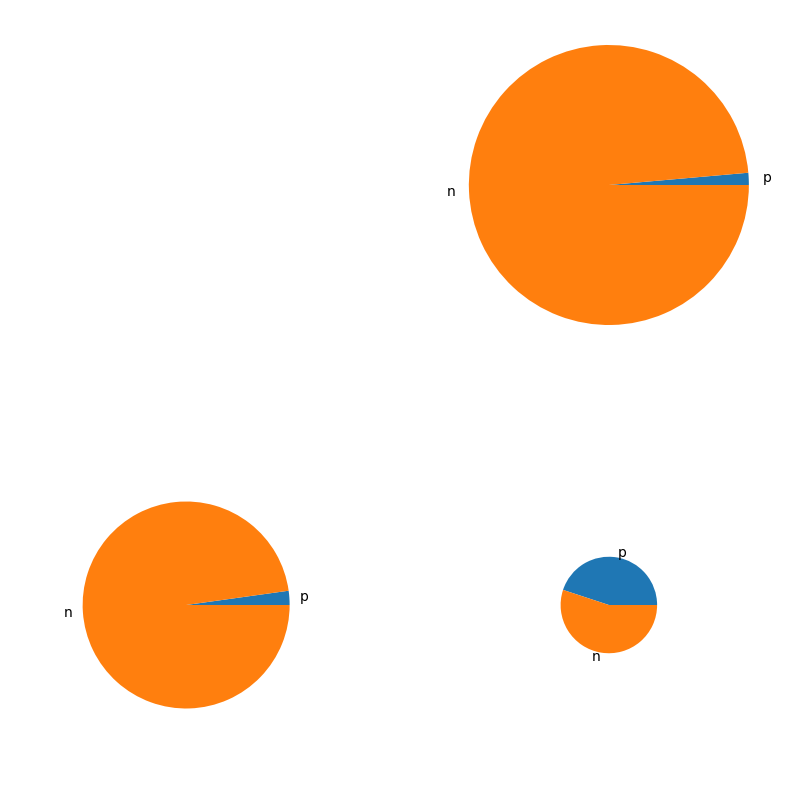

In [13]:
fig,ax = plt.subplots(x,y,figsize=(10,10))
ax = ax.flatten()
sbt = ['p','n']
max_values = max([results[key]['positives']+results[key]['negatives'] for key in results.keys()])
for idx, res in enumerate(results):
    p = results[idx]['positives']
    n = results[idx]['negatives']
    if p == 0:
        p=None
    if n==0:
        n=None
#     import pdb
#     pdb.set_trace()
#     ax[int(idx/5)][idx%5].pie([p,n],labels=sbt)
    if p and n:
        ax[idx].pie([p,n],labels=sbt,radius = (p+n)/max_values)
    else:
        ax[idx].axis('off')

## old

In [14]:
# %%time
# v_t = v.copy()
# for t in tqdm(range(1,51)):#range(1,n_iter+1):
# #     clear_output(wait=True)
#     print('Iter ',t)
#     sigma_t = calc_sigma(t)
#     h_t = np.empty((C,C))
    
#     for i in range(C):
#         for j in range(C):
#             h_t[i,j] = calc_h(nodes,i,j,sigma_t)
    
#     ## step 1: compute Gr
#     for r in tqdm(range(C)):
#         g = []
        
#         for h in range(norm_diss.shape[0]):
#             values_array = np.empty((norm_diss.shape[0],norm_diss.shape[0]))
#             for k in range(h,norm_diss.shape[0]):
#                 rescalc = (
#                     h_t[elements_clusters[k]['cluster'],r]
#                     *distance.euclidean(elements_clusters[k]['element'],elements_clusters[h]['element'])
#                 )
#                 values_array[h,k] = rescalc
#                 values_array[k,h] = rescalc
            
#             val = values_array.sum(axis=1)[h]
#             g.append((h,val))
            
#         g = sorted(g, key= lambda x: x[1])[:q]
        
#         G[r] = np.array([norm_diss[pair[0]] for pair in g])
    
    
# #     print('Iter ',t, '- Weighting')
#     ## step 2: weighting
#     for r in tqdm(range(v_t.shape[0])): #for all lines of v
#         for e_idx in range(v_t.shape[1]): #for all columns of v
#             base_sum = []
            
#             upper = np.sum(
#                 [
#                     (
#                         calc_h(nodes, elements_clusters[k]['cluster'],r, sigma_t)
#                         *distance.euclidean(elements_clusters[k]['element'],G[r][e_idx])
#                     ) 
#                     for k in range(norm_diss.shape[0]) 
#                 ]
#             )
            
#             for element in G[r]:            
#                 lower = np.sum(
#                     [
#                         (
#                             calc_h(nodes, elements_clusters[k]['cluster'],r, sigma_t)
#                             *distance.euclidean(elements_clusters[k]['element'],element)
#                         ) 
#                         for k in range(norm_diss.shape[0]) 
#                     ]
#                 )

#                 base_sum.append(
#                     pow(upper/lower,1/(n-1))
#                 )
            
#             v_t[r][e_idx] = 1/sum(base_sum)
            
# #     print('Iter ',t, '- Assignment')
#     ## step 3: assignment
#     P = [[] for i in range(C)]
#     indices = list(range(norm_diss.shape[0]))
#     elements_clusters = defaultdict()
    
#     for k in tqdm(indices):
#         #calculate f_ek
#         deltas = np.empty(C)
#         for s in range(C):
#             val = sum(
#                 [
#                     calc_h(nodes,s,r,sigma)*D_vr(norm_diss[k],r) for r in range(C)
#                 ]
#             )

#             deltas[s] = val

#         k_cluster = np.argmin(deltas)
#         elements_clusters[k] = {'cluster': k_cluster, 'element': norm_diss[k]}

#         P[k_cluster].append(k)   